In [1]:
import os
import sys
os.environ['SPARK_HOME']='D:/spark330hdp3sc3'
os.environ['PYLIB']=os.environ['SPARK_HOME']+'/python/lib'
sys.path.insert(0,os.environ['PYLIB']+'/py4j-0.10.9.5-src.zip')
sys.path.insert(1,os.environ['PYLIB']+'/pyspark.zip')

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession.builder.appName('TestHive') \
.config('spark.warehouse.dir','/apps/hive/warehouse') \
.enableHiveSupport().getOrCreate()

In [4]:
# Having set the driver and driver options we should have spark representing spark session 
# available straight away
spark.version

'3.3.0'

In [5]:
sc = spark.sparkContext

In [7]:
fileLoc = "D:/ufdata/apachelogs.gz"
logFileRDD = sc.textFile(fileLoc)
print("No of logs " , logFileRDD.count())
logFileRDD.take(2)

No of logs  1043177


['in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839',
 'uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0']

In [8]:
# make provisions for processing the logs
# use a regex to split the line into the nine groups and map it to a sql row of nine columns
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = int(0)
    else:
        size = int(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

In [9]:
# set the log pattern to be used
APACHE_ACCESS_LOG_PATTERN ='^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

In [10]:
# read the log file and use the mapped tuple second part to get a count of successfully parsed
# and failed logs
import sys
import os


def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(fileLoc)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print('Number of invalid logline: %d' % failed_logs.count())
        for line in failed_logs.take(20):
            print('Invalid logline: %s' % line)

    print('Read %d lines, successfully parsed %d lines, failed to parse %d lines' % 
          (parsed_logs.count(), access_logs.count(), failed_logs.count()))
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

Read 1043177 lines, successfully parsed 1043177 lines, failed to parse 0 lines


In [11]:
# TEST Data cleaning
assert(failed_logs.count() == 0)
assert(parsed_logs.count() == 1043177)
assert(access_logs.count() == parsed_logs.count())

In [12]:
# Calculate statistics based on the content size.
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print('Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max()))

Content Size Avg: 17531, Min: 0, Max: 3421948


In [13]:
# Response code analysis
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.collect()
print( 'Found %d response codes' % len(responseCodeToCountList))
print( 'Response Code Counts: %s' % responseCodeToCountList)
assert len(responseCodeToCountList) == 7
assert sorted(responseCodeToCountList) == [(200, 940847), (302, 16244), (304, 79824), (403, 58), (404, 6185), (500, 2), (501, 17)]

Found 7 response codes
Response Code Counts: [(200, 940847), (304, 79824), (302, 16244), (404, 6185), (403, 58), (500, 2), (501, 17)]


In [14]:
# Response Code Graphing with matplotlib
labels = responseCodeToCount.map(lambda x : x[0]).collect()
print(labels)
count = access_logs.count()
fracs = responseCodeToCount.map(lambda x : (float(x[1]) / count)).collect()
print(fracs)

[200, 304, 302, 404, 403, 500, 501]
[0.9019054292799784, 0.07652009198822443, 0.015571662335346735, 0.005929003419362198, 5.5599385339208974e-05, 1.9172201841106543e-06, 1.629637156494056e-05]


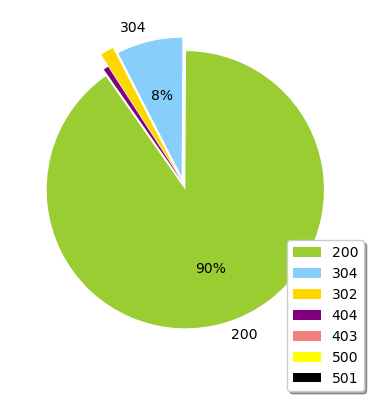

In [15]:
import matplotlib.pyplot as plt


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
plt.show()

In [16]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print('Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20)

Any 20 hosts that have accessed more then 10 times: ['in24.inetnebr.com', 'uplherc.upl.com', 'ix-esc-ca2-07.ix.netcom.com', 'piweba4y.prodigy.com', '133.43.96.45', 'www-c8.proxy.aol.com', 'www-c3.proxy.aol.com', '133.68.18.180', 'www-d3.proxy.aol.com', 'haraway.ucet.ufl.edu', 'www-d4.proxy.aol.com', 'endeavor.fujitsu.co.jp', 'rpgopher.aist.go.jp', '139.230.35.135', 'piweba1y.prodigy.com', '165.213.131.21', 'www-c6.proxy.aol.com', 'gw1.att.com', 'ai.asu.edu', 'pm9.j51.com']


In [21]:
# Top Endpoints
endpointCounts = (access_logs
                  .map(lambda log: (log.endpoint, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print('Top Ten Endpoints: %s' % topEndpoints)
assert topEndpoints == [(u'/images/NASA-logosmall.gif', 59737), 
                        (u'/images/KSC-logosmall.gif', 50452), 
                        (u'/images/MOSAIC-logosmall.gif', 43890), 
                        (u'/images/USA-logosmall.gif', 43664),
                        (u'/images/WORLD-logosmall.gif', 43277), 
                        (u'/images/ksclogo-medium.gif', 41336), 
                        (u'/ksc.html', 28582),
                        (u'/history/apollo/images/apollo-logo1.gif', 26778),
                        (u'/images/launch-logo.gif', 24755), 
                        (u'/', 20292)], 'incorrect Top Ten Endpoints'

Top Ten Endpoints: [('/images/NASA-logosmall.gif', 59737), ('/images/KSC-logosmall.gif', 50452), ('/images/MOSAIC-logosmall.gif', 43890), ('/images/USA-logosmall.gif', 43664), ('/images/WORLD-logosmall.gif', 43277), ('/images/ksclogo-medium.gif', 41336), ('/ksc.html', 28582), ('/history/apollo/images/apollo-logo1.gif', 26778), ('/images/launch-logo.gif', 24755), ('/', 20292)]


In [22]:
not200_or_304 = access_logs.filter(lambda x: x.response_code != (200 or 304))

endpointCountPairTuple = not200_or_304.map(lambda x:(x[3],1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a, b: a+ b)

topTenErrURLs = endpointSum.takeOrdered(10, lambda x: -1 * x[1])
print('Top Ten failed URLs: %s' % topTenErrURLs)

Top Ten failed URLs: [(datetime.datetime(1995, 8, 15, 14, 56, 55), 13), (datetime.datetime(1995, 8, 9, 8, 48, 30), 12), (datetime.datetime(1995, 8, 15, 9, 11, 44), 12), (datetime.datetime(1995, 8, 15, 15, 0, 36), 12), (datetime.datetime(1995, 8, 22, 10, 5, 17), 12), (datetime.datetime(1995, 8, 7, 11, 25, 29), 11), (datetime.datetime(1995, 8, 1, 8, 59, 30), 10), (datetime.datetime(1995, 8, 3, 14, 56, 43), 10), (datetime.datetime(1995, 8, 4, 10, 29, 20), 10), (datetime.datetime(1995, 8, 21, 7, 0, 6), 10)]


In [26]:
# unique hosts
hosts = access_logs.map(lambda log: (log.host))

uniqueHosts = hosts.distinct()

uniqueHostCount = uniqueHosts.count()
print('Unique hosts: %d' % uniqueHostCount)

Unique hosts: 54507


In [27]:
assert uniqueHostCount == 54507, 'incorrect uniqueHostCount'

In [28]:
dayHostCount = access_logs.map(lambda x: (x.date_time.day, x.host))
# dailyHosts = dayHostCount.groupByKey().sortByKey().map(lambda x: (x[0], set(x[1]))).map(lambda x: (x[0], len(x[1]))).cache()
dailyHosts = dayHostCount.groupByKey().sortByKey().map(lambda x: (x[0], len(set(x[1])))).cache()
dailyHostsList = dailyHosts.take(30)
print('Unique hosts per day: %s' % dailyHostsList)

Unique hosts per day: [(1, 2582), (3, 3222), (4, 4190), (5, 2502), (6, 2537), (7, 4106), (8, 4406), (9, 4317), (10, 4523), (11, 4346), (12, 2864), (13, 2650), (14, 4454), (15, 4214), (16, 4340), (17, 4385), (18, 4168), (19, 2550), (20, 2560), (21, 4134), (22, 4456)]


In [29]:
assert dailyHosts.count() == 21, 'incorrect dailyHosts.count()'
assert dailyHostsList == [(1, 2582), (3, 3222), (4, 4190), (5, 2502), (6, 2537), (7, 4106), (8, 4406), (9, 4317), (10, 4523), (11, 4346), (12, 2864), (13, 2650), (14, 4454), (15, 4214), (16, 4340), (17, 4385), (18, 4168), (19, 2550), (20, 2560), (21, 4134), (22, 4456)], 'incorrect dailyHostsList'
assert dailyHosts.is_cached, 'incorrect dailyHosts.is_cached'

In [30]:
# Visualizing unique daily hosts 
daysWithHosts = dailyHosts.map( lambda x : x[0]).collect()
hosts = dailyHosts.map( lambda x : x[1]).collect()
test_days =[x for x in  range(1, 23) if x != 2]
assert daysWithHosts == test_days, 'incorrect days'
assert hosts == [2582, 3222, 4190, 2502, 2537, 4106, 4406, 4317, 4523, 4346, 2864, 2650, 4454, 4214, 4340, 4385, 4168, 2550, 2560, 4134, 4456], 'incorrect hosts'

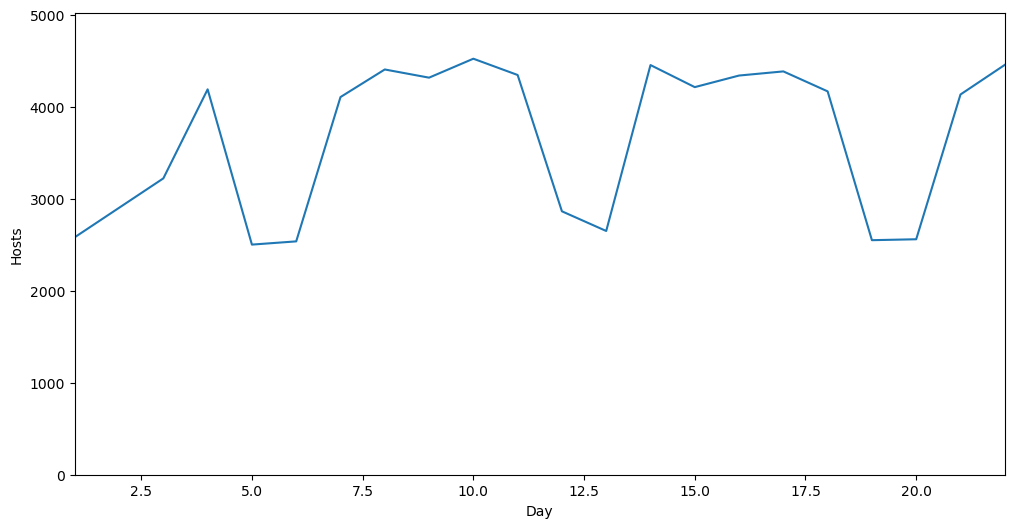

In [33]:
fig = plt.figure(figsize=(12, 6), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
# plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)
plt.show()

In [34]:
# Average number of daily requests per hosts
dayAndHostTuple =  access_logs.map(lambda s : (s.date_time.day,s.host))

groupedByDay = dayAndHostTuple.groupByKey()

sortedByDay = groupedByDay.sortByKey().map(lambda x:(x[0], int(len(x[1])/len(set(x[1])))))

avgDailyReqPerHost = (sortedByDay
                      .cache())
avgDailyReqPerHostList = avgDailyReqPerHost.take(30)
print('Average number of daily requests per Hosts is %s' % avgDailyReqPerHostList)

Average number of daily requests per Hosts is [(1, 13), (3, 12), (4, 14), (5, 12), (6, 12), (7, 13), (8, 13), (9, 14), (10, 13), (11, 14), (12, 13), (13, 13), (14, 13), (15, 13), (16, 13), (17, 13), (18, 13), (19, 12), (20, 12), (21, 13), (22, 12)]


In [35]:
assert avgDailyReqPerHostList == [(1, 13), (3, 12), (4, 14), (5, 12), (6, 12),
                                  (7, 13), (8, 13), (9, 14), (10, 13), (11, 14), (12, 13),
                                  (13, 13), (14, 13), (15, 13), (16, 13), (17, 13), 
                                  (18, 13), (19, 12), (20, 12), (21, 13), (22, 12)], 'incorrect avgDailyReqPerHostList'
assert avgDailyReqPerHost.is_cached, 'incorrect avgDailyReqPerHost.is_cache'

In [36]:
# find bad records
badRecords = (access_logs
              .filter(lambda s: s.response_code == 404).cache())
print('Found %d 404 URLs' % badRecords.count())

Found 6185 404 URLs


In [37]:
assert badRecords.count() == 6185, 'incorrect badRecords.count()'
assert badRecords.is_cached, 'incorrect badRecords.is_cached'

In [38]:
# the end points throwing errors

badEndpoints = badRecords.map(lambda s:s.endpoint)

badUniqueEndpoints = badEndpoints.distinct()

badUniqueEndpointsPick40 = badUniqueEndpoints.take(40)
print('404 URLS: %s' % badUniqueEndpointsPick40)

404 URLS: ['/shuttle/resources/orbiters/discovery.gif', '/pub/winvn/release.txt', '/www/software/winvn/winvn.html', '/history/history.htm', '/elv/DELTA/uncons.htm', '/sts-71/launch/', '/history/apollo/apollo-13.html', '/history/apollo/a-001/a-001-patch-small.gif', '/history/apollo/a-001/movies/', '/history/apollo/a-001/images/', '/history/apollo/a-004/a-004-patch-small.gif', '/history/apollo/a-004/movies/', '/pub/winvn/readme.txt', '/shuttle/resources/orbiters/atlantis.gif', '/ksc.htm1', '/history/apollo/html', '/images/Nasa-logo.gif', '/history/apollo/images/little-joe.jpg', '/nasa/nasa_hottopics.html', '/people/nasa-cm/jmd.html', '/persons/astronauts/thagar.html', '/IUMA/lib/IUMA-title.gif', '/IUMA/lib/htu_button.gif', '/shuttle/missions/sts-63/sts-63-press-kit.tx', '/shuttle/technology/sts_newsreflsts_ovcomm.html', '/l', '/ksc/html', '/\\\\yahoo.com', '/MDSS/', '/M/on-this-day', '/history/apollo/sa-1/sa-1-patch-small.gif', '/history/apollo/sa-1/images/', '/history/apollo/sa-1/movies

In [39]:
# the top 20 404 urls
badEndpointsCountPairTuple = badRecords.map(lambda s:(s.endpoint,1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda a,b: a + b)

badEndpointsTop20 = badEndpointsSum.takeOrdered(20,lambda s: -1 * s[1])
print('Top Twenty 404 URLs: %s' % badEndpointsTop20)

Top Twenty 404 URLs: [('/pub/winvn/readme.txt', 633), ('/pub/winvn/release.txt', 494), ('/shuttle/missions/STS-69/mission-STS-69.html', 431), ('/images/nasa-logo.gif', 319), ('/elv/DELTA/uncons.htm', 178), ('/shuttle/missions/sts-68/ksc-upclose.gif', 156), ('/history/apollo/sa-1/sa-1-patch-small.gif', 146), ('/images/crawlerway-logo.gif', 120), ('/://spacelink.msfc.nasa.gov', 117), ('/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 100), ('/history/apollo/a-001/a-001-patch-small.gif', 97), ('/images/Nasa-logo.gif', 85), ('/shuttle/resources/orbiters/atlantis.gif', 64), ('/history/apollo/images/little-joe.jpg', 62), ('/images/lf-logo.gif', 59), ('/shuttle/resources/orbiters/discovery.gif', 56), ('/shuttle/resources/orbiters/challenger.gif', 54), ('/robots.txt', 53), ('/elv/new01.gif>', 43), ('/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 38)]


In [40]:
assert badEndpointsTop20 == [(u'/pub/winvn/readme.txt', 633), 
                             (u'/pub/winvn/release.txt', 494), 
                             (u'/shuttle/missions/STS-69/mission-STS-69.html', 431), 
                             (u'/images/nasa-logo.gif', 319), 
                             (u'/elv/DELTA/uncons.htm', 178), 
                             (u'/shuttle/missions/sts-68/ksc-upclose.gif', 156), 
                             (u'/history/apollo/sa-1/sa-1-patch-small.gif', 146), 
                             (u'/images/crawlerway-logo.gif', 120), (u'/://spacelink.msfc.nasa.gov', 117), 
                             (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 100),
                             (u'/history/apollo/a-001/a-001-patch-small.gif', 97), 
                             (u'/images/Nasa-logo.gif', 85), (u'/shuttle/resources/orbiters/atlantis.gif', 64),
                             (u'/history/apollo/images/little-joe.jpg', 62), (u'/images/lf-logo.gif', 59), 
                             (u'/shuttle/resources/orbiters/discovery.gif', 56), 
                             (u'/shuttle/resources/orbiters/challenger.gif', 54), 
                             (u'/robots.txt', 53), (u'/elv/new01.gif>', 43), 
                             (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 38)], 'incorrect badEndpointsTop20'

In [41]:
#  Listing the Top Twenty-five 404 Response Code Hosts

errHostsCountPairTuple = badRecords.map(lambda s: (s.host,1))

errHostsSum = errHostsCountPairTuple.reduceByKey(lambda a,b : a + b)

errHostsTop25 = errHostsSum.takeOrdered(25, lambda x: -1 * x[1])
print('Top 25 hosts that generated errors: %s' % errHostsTop25)

Top 25 hosts that generated errors: [('piweba3y.prodigy.com', 39), ('maz3.maz.net', 39), ('gate.barr.com', 38), ('ts8-1.westwood.ts.ucla.edu', 37), ('nexus.mlckew.edu.au', 37), ('m38-370-9.mit.edu', 37), ('204.62.245.32', 33), ('spica.sci.isas.ac.jp', 27), ('163.206.104.34', 27), ('www-d4.proxy.aol.com', 26), ('www-c4.proxy.aol.com', 25), ('203.13.168.17', 25), ('203.13.168.24', 25), ('internet-gw.watson.ibm.com', 24), ('piweba5y.prodigy.com', 23), ('scooter.pa-x.dec.com', 23), ('crl5.crl.com', 23), ('onramp2-9.onr.com', 22), ('slip145-189.ut.nl.ibm.net', 22), ('198.40.25.102.sap2.artic.edu', 21), ('gn2.getnet.com', 20), ('msp1-16.nas.mr.net', 20), ('dial055.mbnet.mb.ca', 19), ('isou24.vilspa.esa.es', 19), ('tigger.nashscene.com', 19)]


In [42]:
assert len(errHostsTop25) == 25, 'length of errHostsTop25 is not 25'
assert len(set(errHostsTop25) - set([(u'maz3.maz.net', 39),
                                     (u'piweba3y.prodigy.com', 39),
                                     (u'gate.barr.com', 38), 
                                     (u'm38-370-9.mit.edu', 37), 
                                     (u'ts8-1.westwood.ts.ucla.edu', 37),
                                     (u'nexus.mlckew.edu.au', 37),
                                     (u'204.62.245.32', 33), 
                                     (u'163.206.104.34', 27), 
                                     (u'spica.sci.isas.ac.jp', 27),
                                     (u'www-d4.proxy.aol.com', 26),
                                     (u'www-c4.proxy.aol.com', 25), 
                                     (u'203.13.168.24', 25),
                                     (u'203.13.168.17', 25),
                                     (u'internet-gw.watson.ibm.com', 24),
                                     (u'scooter.pa-x.dec.com', 23), 
                                     (u'crl5.crl.com', 23), 
                                     (u'piweba5y.prodigy.com', 23),
                                     (u'onramp2-9.onr.com', 22), (u'slip145-189.ut.nl.ibm.net', 22), 
                                     (u'198.40.25.102.sap2.artic.edu', 21), 
                                     (u'gn2.getnet.com', 20), 
                                     (u'msp1-16.nas.mr.net', 20),
                                     (u'isou24.vilspa.esa.es', 19), 
                                     (u'dial055.mbnet.mb.ca', 19), 
                                     (u'tigger.nashscene.com', 19)])) == 0, 'incorrect errHostsTop25'


In [43]:
# Listing 404 Response Codes per Day

errDateCountPairTuple = badRecords.map(lambda x:(x.date_time.day,1))

errDateSum = errDateCountPairTuple.reduceByKey( lambda a,b: a + b)

errDateSorted = (errDateSum.sortByKey()
                 .cache())

errByDate = errDateSorted.collect()
print('404 Errors by day: %s' % errByDate)

404 Errors by day: [(1, 243), (3, 303), (4, 346), (5, 234), (6, 372), (7, 532), (8, 381), (9, 279), (10, 314), (11, 263), (12, 195), (13, 216), (14, 287), (15, 326), (16, 258), (17, 269), (18, 255), (19, 207), (20, 312), (21, 305), (22, 288)]


In [44]:
assert errByDate == [(1, 243), (3, 303), (4, 346), (5, 234), (6, 372), (7, 532), 
                     (8, 381), (9, 279), (10, 314), (11, 263), (12, 195), (13, 216), 
                     (14, 287), (15, 326), (16, 258), (17, 269), (18, 255), (19, 207), 
                     (20, 312), (21, 305), (22, 288)], 'incorrect errByDate'
assert errDateSorted.is_cached, 'incorrect errDateSorted.is_cached'

#### Visualizing the 404 Response Codes by Day

In [45]:
daysWithErrors404 = errDateSorted.map(lambda x: x[0]).collect()
errors404ByDay = errDateSorted.map(lambda x: x[1]).collect()

In [46]:
assert daysWithErrors404 == [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'incorrect daysWithErrors404'
assert errors404ByDay == [243, 303, 346, 234, 372, 532, 381, 279, 314, 263, 195, 216, 287, 326, 258, 269, 255, 207, 312, 305, 288], 'incorrect errors404ByDay'

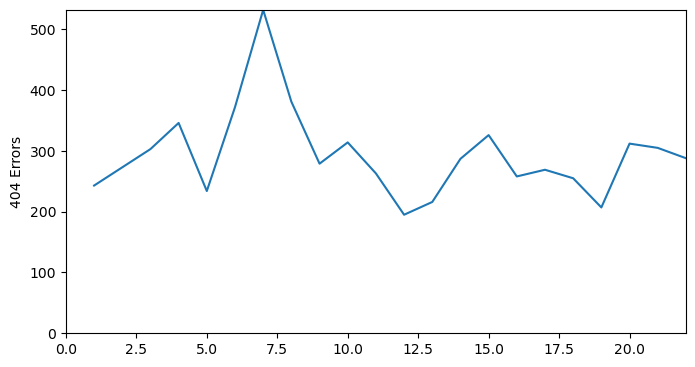

In [48]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
# plt.grid(b=True, which='major', axis='y')plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)
plt.show()

#### **Hourly 404 Response Codes**
#### Using the RDD `badRecords` you cached in the part (4a) and by hour of the day and in increasing order, create an RDD containing how many requests had a 404 return code for each hour of the day (midnight starts at 0). Cache the resulting RDD hourRecordsSorted and print that as a list.

In [49]:
hourCountPairTuple = badRecords.map(lambda x:(x.date_time.hour,1))

hourRecordsSum = hourCountPairTuple.reduceByKey(lambda a,b : a + b)

hourRecordsSorted = (hourRecordsSum
                     .sortByKey().cache())

errHourList = hourRecordsSorted.collect()
print('Top hours for 404 requests: %s' % errHourList)

Top hours for 404 requests: [(0, 175), (1, 171), (2, 422), (3, 272), (4, 102), (5, 95), (6, 93), (7, 122), (8, 199), (9, 185), (10, 329), (11, 263), (12, 438), (13, 397), (14, 318), (15, 347), (16, 373), (17, 330), (18, 268), (19, 269), (20, 270), (21, 241), (22, 234), (23, 272)]


In [50]:
# TEST Hourly 404 response codes (4h)
assert errHourList == [(0, 175), (1, 171), (2, 422), (3, 272), (4, 102), (5, 95), (6, 93),
                       (7, 122), (8, 199), (9, 185), (10, 329), (11, 263), (12, 438), (13, 397), 
                       (14, 318), (15, 347), (16, 373), (17, 330), (18, 268), (19, 269), (20, 270), 
                       (21, 241), (22, 234), (23, 272)], 'incorrect errHourList'
assert hourRecordsSorted.is_cached, 'incorrect hourRecordsSorted.is_cached'

#### **(4i) Visualizing the 404 Response Codes by Hour**

In [51]:
hoursWithErrors404 = hourRecordsSorted.map(lambda x: x[0]).collect()
errors404ByHours = hourRecordsSorted.map(lambda x:x[1]).collect()

In [52]:
assert hoursWithErrors404 == [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                              15, 16, 17, 18, 19, 20, 21, 22, 23], 'incorrect hoursWithErrors404'
assert errors404ByHours == [175, 171, 422, 272, 102, 95, 93, 122, 199, 185, 329, 263, 438, 397, 318, 347, 
                            373, 330, 268, 269, 270, 241, 234, 272], 'incorrect errors404ByHours'

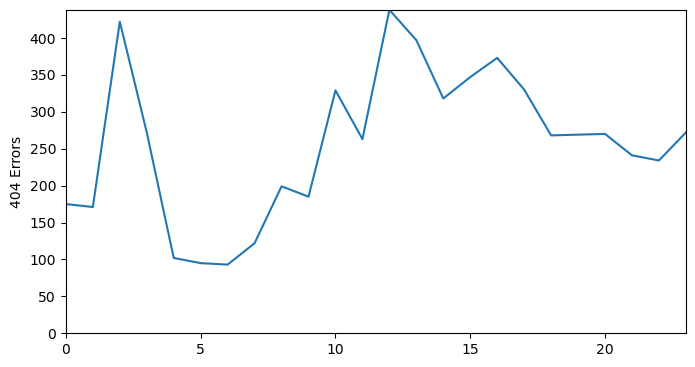

In [55]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)
plt.show()